Get all the links from a website

In [54]:
url = "https://www.stanford.edu"
domain = "www.stanford.edu"

### Get all links in a web page


In [56]:
from bs4 import BeautifulSoup
import requests

def get_links(url: str, domain: str) -> list[str]:
    try:
        r = requests.get(url)
        if not r.headers['Content-Type'].startswith("text/html"):
            return []
        
        html_doc = r.text
        links = set()
        soup = BeautifulSoup(html_doc, 'html.parser')
        for tag in soup.find_all('a'):
            link = tag.get('href')
            if link is None:
                continue
            if link.startswith("#") or link.startswith("mailto:"):
                continue
            if link.startswith(url):
                links.add(link)
            elif link.startswith("/"):
                link = link[1:]
                links.add(f"{url}/{link}")

    except Exception as e:
        print(e)
        return []

    return list(links)

In [57]:
links = get_links(url, domain)
len(links)

23

In [ ]:
links

### Crawl all the links in the same domain

In [59]:
from collections import deque

def get_all_links_same_domain(url: str, domain: str) -> list[str]:
    seen = set([url])
    links = deque([url])
    while links:
        current_url = links.popleft()
        for link in get_links(current_url, domain):
            if link not in seen:
                seen.add(link)
                links.append(link)

    return list(seen)

In [60]:
all_links = get_all_links_same_domain(url, domain)
len(all_links)

33

### Crawl all texts from a domain

In [63]:


import os

def crawl(url):
    for link in all_links:
        if not os.path.exists("text"):
            os.makedirs("text")

        if not os.path.exists(f"text/{domain}"):
            os.makedirs(f"text/{domain}")

        try:
            r = requests.get(link)
            if not r.headers['Content-Type'].startswith("text/html"):
                continue

            html_doc = r.text
            soup = BeautifulSoup(html_doc, 'html.parser')
            text = soup.get_text()
            if not text:
                continue

            with open(f"text/{domain}/{link[8:].replace('/', '_')}.txt", "w") as f:
                if ("You need to enable Javascript to run this app." in text):
                    print("Unable to parse page " + url + " due to Javascript being required.")

                f.write(text)
        except Exception as e:
            print(e)
            continue


In [64]:
crawl(url)

### Save the crawled texts into a dataframe

In [82]:
import os
import pandas as pd

def remove_new_lines(text: str) -> str:
    return text.replace('\n', ' ').replace('\r', ' ')

texts = []
for file in os.listdir(f"text/{domain}/"):
    with open(f"text/{domain}/{file}", "r") as f:
        title = file[16:-4].replace('_', ' ')
        text = f.read()
        texts.append((title, title + ". " + remove_new_lines(text)))

df = pd.DataFrame(texts, columns=['title', 'text'])
df.to_csv(f"processed/{domain}.csv", index=False)


Add token count column to the dataframe

<Axes: >

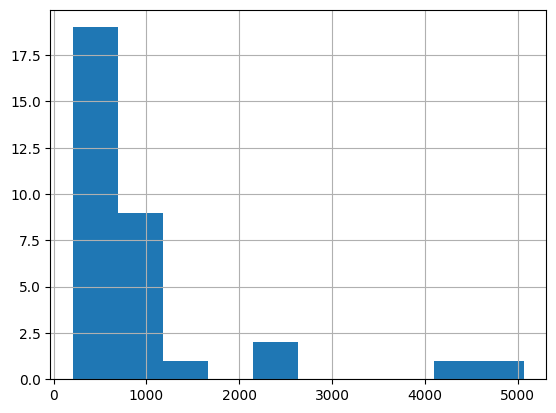

In [170]:
import tiktoken

tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv(f"processed/{domain}.csv")

df['n_tokens'] = df['text'].apply(lambda x: len(tokenizer.encode(x)))

df.head()

df['n_tokens'].hist()

### Break down pages into shorter chunks.

In [171]:
def break_chunks(text: str, max_tokens: int) -> list[tuple[str, int]]:
    count_so_far = 0
    sentences = []
    chunks = []

    for sentence in text.split('. '):
        curr_token = len(tokenizer.encode(sentence))
        if count_so_far + curr_token > max_tokens:
            chunks.append(('. '.join(sentences), count_so_far))
            count_so_far = curr_token
            sentences = [sentence]
        else:
            count_so_far += curr_token
            sentences.append(sentence)
    
    return chunks

In [172]:
def transform(df: pd.DataFrame, max_tokens: int) -> pd.DataFrame:
    chunks = []
    for _, row in df.iterrows():
        chunks.extend(break_chunks(row['text'], max_tokens))

    return pd.DataFrame(chunks, columns=['text', 'n_tokens'])

<Axes: >

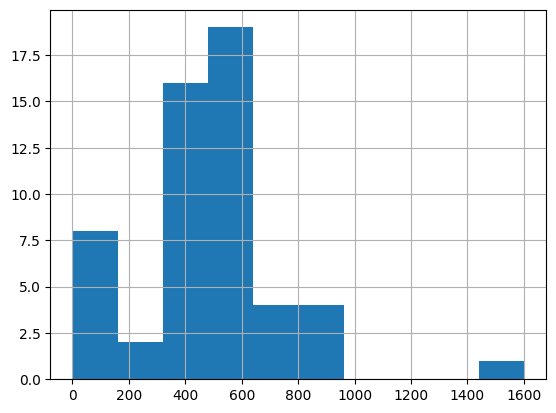

In [173]:
df = transform(df, 500)
df['n_tokens'].hist()

### Create embedding on chunks

In [176]:
import openai

df["embeddings"] = df["text"].apply(lambda x: openai.Embedding.create(input=x, model="text-embedding-ada-002")['data'][0]['embedding'])
df.head()

,text,n_tokens,embeddings
0,research . Research – Stanford Univers...,489,"[0.0013005564687773585, 0.0015043378807604313,..."
1,. Stanford University ...,361,"[0.008646012283861637, -0.006314127705991268, ..."
2,Everyone has a different flavor of intelligenc...,485,"[0.026591764762997627, 0.0007826302316971123, ..."
3,admission. Admission – Stanford Univer...,487,"[0.024407632648944855, -0.0093003548681736, -0..."
4,list research,2,"[-0.022977428510785103, 0.010884045623242855, ..."


In [177]:
df.to_csv(f"processed/{domain}_embeddings.csv", index=False)

### Convert string embedding to list object

In [179]:
import numpy as np

df= pd.read_csv(f"processed/{domain}_embeddings.csv", index_col=False)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()

,text,n_tokens,embeddings
0,research . Research – Stanford Univers...,489,"[0.0013005564687773585, 0.0015043378807604313,..."
1,. Stanford University ...,361,"[0.008646012283861637, -0.006314127705991268, ..."
2,Everyone has a different flavor of intelligenc...,485,"[0.026591764762997627, 0.0007826302316971123, ..."
3,admission. Admission – Stanford Univer...,487,"[0.024407632648944855, -0.0093003548681736, -0..."
4,list research,2,"[-0.022977428510785103, 0.010884045623242855, ..."


Calculate Distance use openai distance_from_embeddings

### Create context for query

In [197]:
from openai.embeddings_utils import distances_from_embeddings

def create_context(query: str, df: pd.DataFrame, max_tokens: int) -> str:
    context = []
    token_so_far = 0
    query_embedding = openai.Embedding.create(
    input=query, model="text-embedding-ada-002")['data'][0]['embedding']

    df['distances'] = distances_from_embeddings(
    query_embedding, df.embeddings, distance_metric="cosine")

    for _, row in df.sort_values('distances', ascending=True).iterrows():
        token_so_far += row['n_tokens']
        context.append(row['text'])
        if token_so_far > max_tokens:
            break

    return ("\n\n###\n\n").join(context)

In [198]:
context = create_context("what is the history of stanford?", df, 3000)

In [ ]:
context

### Chat with context

In [202]:
import openai

def chat(query: str, df: pd.DataFrame, max_tokens: int, debug: bool = False) -> str:
    context = create_context(query, df, max_tokens)
    if debug:
        print(context)
    try: 
        response = openai.ChatCompletion.create(
            model="gpt-4",
            temperature=0,
            messages=[
                {"role": "user", "content": f"Anser the question based on the context below, and if the question can't be answered based on the context say \"I don't know\" \n\mContext:{context}\n\n---\n\nQuestion: {query}\n\nAnswer:"}]
                )
    except Exception as e:
        print(e)
        return
    
    return response['choices'][0]['message']['content']

In [204]:
response = chat("What is the culture of stanford", df, 3000)
response

'The culture of Stanford is characterized by its intellectual vitality and irreverence. It is a place where everyone has a different flavor of intelligence. The university is founded on a bedrock of societal purpose and is committed to educating students for lives of leadership and purposeful contribution, advancing fundamental knowledge and cultivating creativity, and accelerating solutions and amplifying their impact. It also has a culture of interdisciplinary collaboration that drives discovery and innovation vital to the world. The university is also deliberate in its recruitment of a diverse student body and seeks to provide all students with the opportunity to learn from each other’s experiences and to think critically about their own views and preconceptions.'